In [0]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms

In [0]:
import matplotlib.pyplot as plt
import torch.optim as optim

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# Loading model

# For loading to CPU, use the following:
#device = torch.device('cpu')
#model = Net()
#model.load_state_dict(torch.load('./MNIST.pt', map_location=device))


# For loading to GPU, use the following:
device = torch.device("cuda")
model = Net()
model.load_state_dict(torch.load('./MNIST.pt'))
model.to(device)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [7]:
model.eval()

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

#FGSM

In [0]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [0]:
for X,y in testloader:
    X,y = X.to(device), y.to(device)
    break
    
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

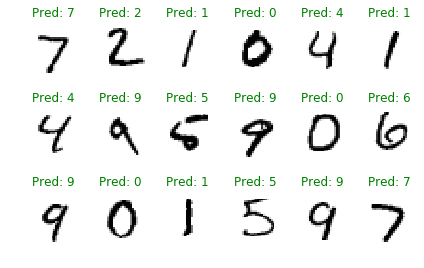

In [11]:
### Illustrate original predictions
y_pred = model(X)
plot_images(X, y, y_pred, 3, 6)

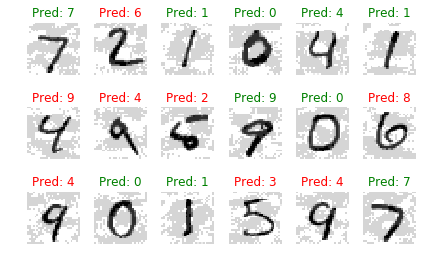

In [27]:
### Illustrate attacked images
delta = fgsm(model, X, y, 0.2)
yp = model(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [0]:
# test error against attack
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [28]:
print("CNN test error against FGSM:", epoch_adversarial(model, testloader, fgsm, 0.2)[0])

CNN test error against FGSM: 0.4798


# Projected Gradient

In [0]:
def pgd(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

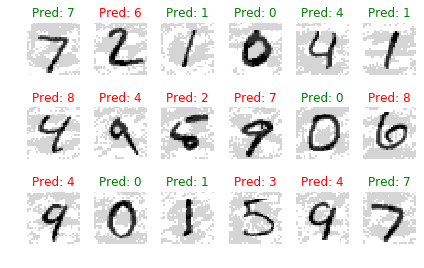

In [30]:
### Illustrate attacked images
delta = pgd(model, X, y, 0.2, 1e4, 1000)
yp = model(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [33]:
print("CNN test error against pgd:", epoch_adversarial(model, testloader, pgd, 0.2, 1e4, 50)[0])

CNN test error against FGSM: 0.5652


#I-FGSM

In [0]:
def i_fgsm(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

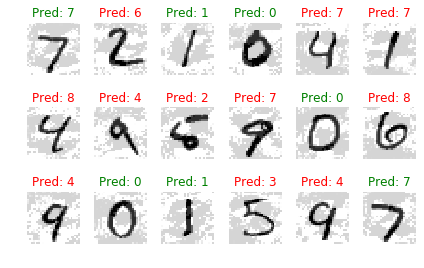

In [37]:
delta = i_fgsm(model, X, y, epsilon=0.2, alpha=2e-2, num_iter=40)
yp = model(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [43]:
print("CNN test error against I-FGSM:", epoch_adversarial(model, testloader, i_fgsm, 0.2, 2e-2, 40)[0])

CNN test error against I-FGSM: 0.5866


#I-FGSM with Restart

In [0]:
def i_fgsm_restart(model, X, y, epsilon, alpha, num_iter, restarts):
    """ Construct PGD adversarial examples on the samples X, with random restarts"""
    max_loss = torch.zeros(y.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)
    
    for i in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
        
        for t in range(num_iter):
            loss = nn.CrossEntropyLoss()(model(X + delta), y)
            loss.backward()
            delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
            delta.grad.zero_()
        
        all_loss = nn.CrossEntropyLoss(reduction='none')(model(X+delta),y)
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)
        
    return max_delta

In [42]:
print("CNN against I-FGSM with Restart:", epoch_adversarial(model, testloader, i_fgsm_restart, 0.2, 2e-2, 40, 10)[0])

CNN against I-FGSM with Restart: 0.594


#Targeted I-FGSM

In [0]:
def i_fgsm_targ(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = (yp[:,y_targ] - yp.gather(1,y[:,None])[:,0]).sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

Targeted attack is observably harder

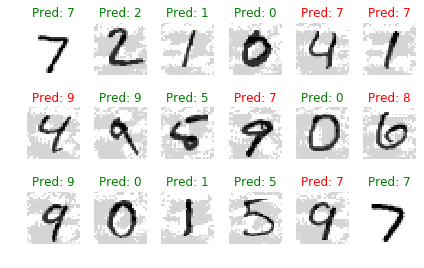

In [47]:
delta = i_fgsm_targ(model, X, y, epsilon=0.2, alpha=2e-2, num_iter=40, y_targ=7)
yp = model(X + delta)
plot_images(X+delta, y, yp, 3, 6)

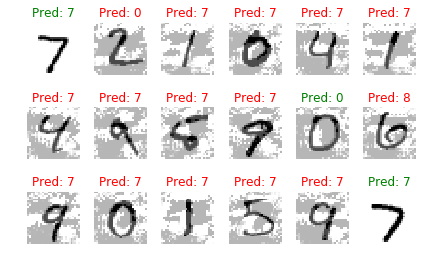

In [48]:
delta = i_fgsm_targ(model, X, y, epsilon=0.4, alpha=2e-2, num_iter=40, y_targ=7)
yp = model(X + delta)
plot_images(X+delta, y, yp, 3, 6)